# NMF and co-segmentation.
Works best with 1 bin, tolerance of 0.1, and starting from m/z 600 (skipping the first 300.)

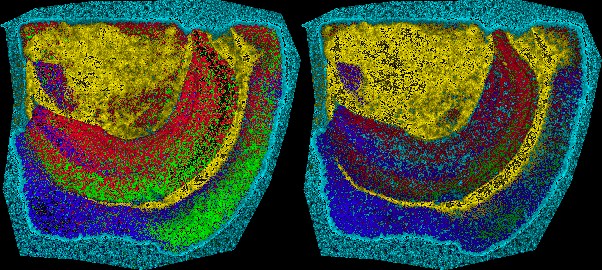

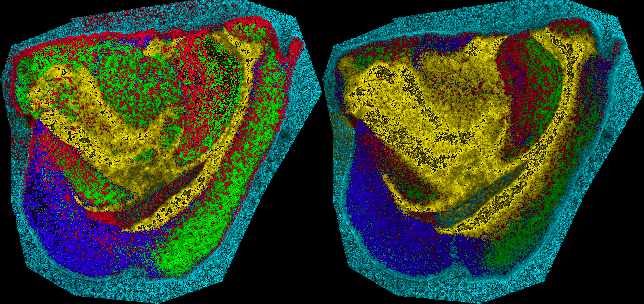

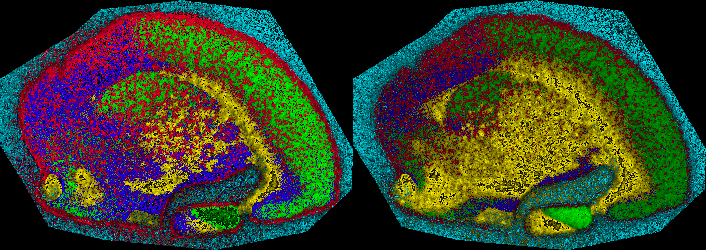

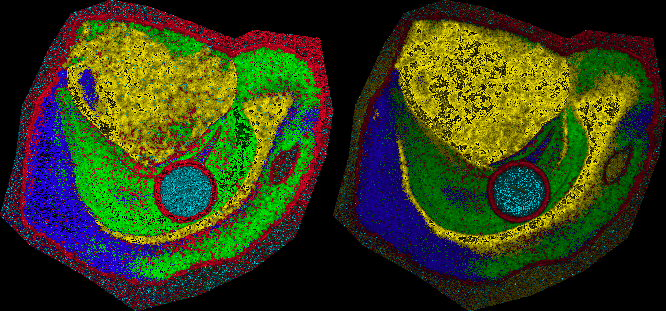

In [184]:
from sklearn.decomposition import NMF
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import cv2
import numpy as np
from typing import List, Dict
import math
from visualizations import show_factorization_on_image
import glob
from PIL import Image
from matplotlib import pyplot as plt
import math
import warnings

warnings.filterwarnings('ignore')
paths = glob.glob("D:\\maldi\\tol_01_binarysearch_1_bin\\*.npy")
NUM_COMPONENTS = 5
_cmap = plt.cm.get_cmap('gist_rainbow')
colors_for_components = [
    np.array(
        _cmap(i)) for i in np.arange(
        0,
        1,
        1.0 /
        NUM_COMPONENTS)]

data = []

components = {}

for path in paths:
    region = path.split("\\")[-1].split(".")[0]
    img = np.load(path)
    img = img[:, :,  300: ]
    img = img / (1e-6 + np.median(img, axis=-1)[:, :, None])    
    vector = img.reshape((-1, img.shape[-1]))
    model = NMF(n_components=NUM_COMPONENTS, init='random', random_state=0)
    W = model.fit_transform(vector)
    H = model.components_
    components[path] = H
    explanations = W.transpose().reshape(NUM_COMPONENTS, img.shape[0], img.shape[1])
    normalized_by_spatial_sum = explanations / explanations.sum(axis=(1, 2))[:, None, None]
    normalized_by_spatial_sum = normalized_by_spatial_sum / np.percentile(normalized_by_spatial_sum, 99, axis=(1, 2) )[:, None, None]
    normalized_by_spatial_sum = normalized_by_spatial_sum[0 : , :, :]    
    normalized_by_global_percentile = explanations / np.percentile(explanations, 99, axis=(0, 1, 2))
    spatial_sum_visualization = show_factorization_on_image(np.zeros(shape=((img.shape[0], img.shape[1], 3))),
                                                normalized_by_spatial_sum,
                                                image_weight=0.0,
                                                colors=colors_for_components[0: ])
    global_percentile_visualization = show_factorization_on_image(np.zeros(shape=((img.shape[0], img.shape[1], 3))),
                                                normalized_by_global_percentile,
                                                image_weight=0.0,
                                                colors=colors_for_components[0: ])


    
    display(Image.fromarray(np.hstack((spatial_sum_visualization, global_percentile_visualization))))

In [188]:
# Now do co-segmentation
import glob
from PIL import Image
from matplotlib import pyplot as plt
import math
import numpy as np
import warnings
warnings.filterwarnings('ignore')

paths = glob.glob("D:\\maldi\\tol_01_binarysearch_1_bin\\*.npy")
NUM_COMPONENTS = 5

_cmap = plt.cm.get_cmap('gist_rainbow')
colors_for_components = [
    np.array(
        _cmap(i)) for i in np.arange(
        0,
        1,
        1.0 /
        NUM_COMPONENTS)]

data = []
images = []


for path in paths:
    region = path.split("\\")[-1].split(".")[0]
    img = np.load(path)
    img = img[:, :, 600:]
    img = img / (1e-6 + np.median(img, axis=-1)[:, :, None])
    images.append(img)
print("image shape", img.shape)
img = np.concatenate([img.reshape(-1, images[0].shape[-1]) for img in images], axis=0)
vector = img.reshape((-1, img.shape[-1]))
model = NMF(n_components=NUM_COMPONENTS, init='random', random_state=0, max_iter=200, alpha_W=10, l1_ratio=0.5)
W = model.fit_transform(vector)
H = model.components_
print(W.shape, H.shape)
np.save("h_cosegmentation.npy", H)

image shape (311, 333, 401)
(370971, 5) (5, 401)


# Visualize the CO-Segmentation results

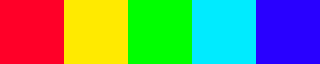

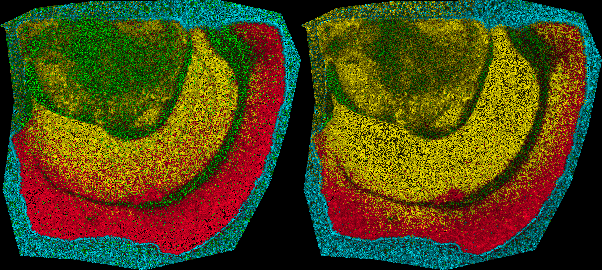

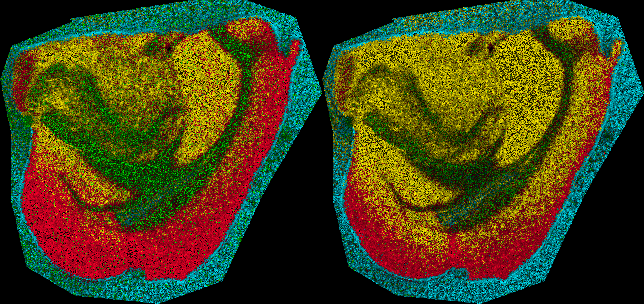

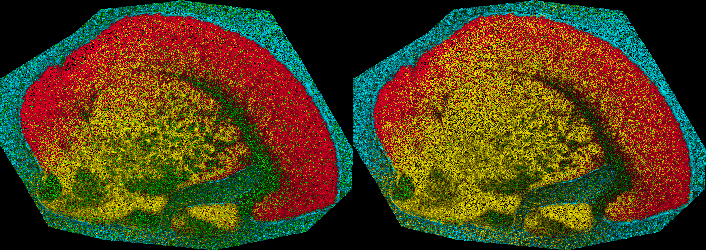

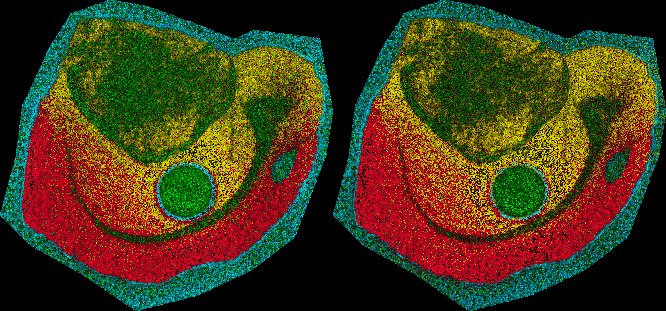

In [190]:
from visualizations import visualizations_from_explanations

display_colors = []
for color in colors_for_components:
    a = np.ones((64, 64, 3), dtype=np.float32)
    a[:, :, :] = color[:3]
    display_colors.append(a)
display_colors = np.hstack(display_colors)
display(Image.fromarray(np.uint8(255 * display_colors)))

elements = 0
for index, img in enumerate(images):
    img_elements = img.shape[0] * img.shape[1]
    w = W[elements : elements + img_elements, :].copy()
    elements = elements + img_elements
    explanations = w.transpose().reshape(NUM_COMPONENTS, img.shape[0], img.shape[1])
    explanations[4, :] = 0
    spatial_sum_visualization, global_percentile_visualization, _, _ = visualizations_from_explanations(img, explanations, colors_for_components)
    display(Image.fromarray(np.hstack((spatial_sum_visualization, global_percentile_visualization))))

# Solve for W with the given H, and save the region pixel results in values_per_region

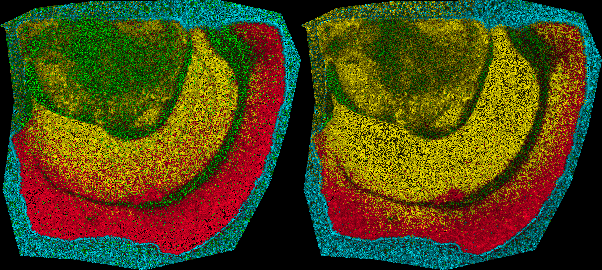

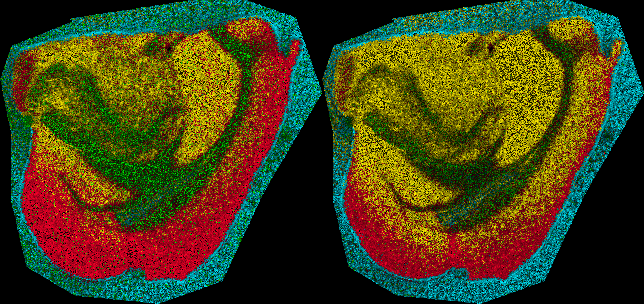

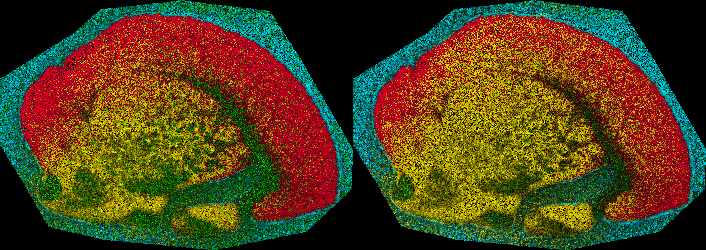

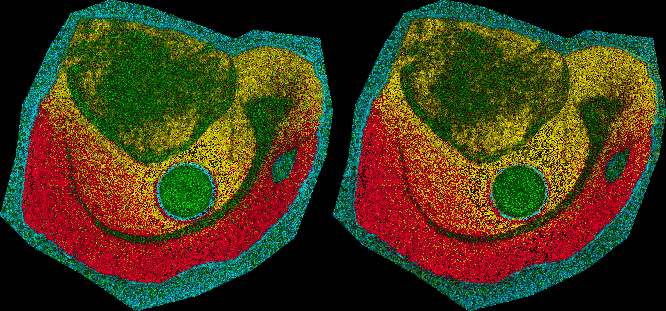

In [193]:
from sklearn.decomposition import non_negative_factorization
from visualizations import visualizations_from_explanations
from collections import defaultdict


paths = glob.glob("D:\\maldi\\tol_01_binarysearch_1_bin\\*.npy")
high_res_paths = glob.glob("D:\\maldi\\tol_None_5_bins\\*.npy")
H = np.load("h_cosegmentation.npy")

values_per_region = defaultdict(list)
for index, (path, high_res_path) in enumerate(zip(paths, high_res_paths)):
    img = np.load(path)
    img = img[:, :,  600 : ]
    img = img / (1e-6 + np.median(img, axis=-1)[:, :, None])
    high_res = np.load(high_res_path)
    high_res = high_res[:, :,  : ]
    high_res = high_res / (1e-6 + np.median(high_res, axis=-1)[:, :, None])
    vector = img.reshape((-1, img.shape[-1]))

    w_new, h_new, n_iter = non_negative_factorization(vector, H=H, W=None, n_components=NUM_COMPONENTS, update_H=False, random_state=0)
    explanations = w_new.transpose().reshape(NUM_COMPONENTS, img.shape[0], img.shape[1])
    explanations[4, :] = 0
    spatial_sum_visualization, global_percentile_visualization, normalized_sum, normalized_percentile = visualizations_from_explanations(img, explanations, colors_for_components)

    segmentation_mask = normalized_sum.argmax(axis=0)
    for v in range(NUM_COMPONENTS):
        mask = np.uint8(segmentation_mask == v) * 255
        mask[img.max(axis=-1) == 0] = 0
        values_per_region[v].extend(list(high_res[mask > 0]))
        Image.fromarray(mask).save(f"{index}_{v}.png")

    display(Image.fromarray(np.hstack((spatial_sum_visualization, global_percentile_visualization))))

# Get the m/z values from Cortex / Hippocampus, and compare their point clouds

0 330.0 0.7965037362414585
0 718.6 0.7089385559350501
0 719.6 0.7040699972081403
0 747.4 0.7246521940011983
0 748.6 0.7235278662607513
0 749.6 0.7152873259230345
0 762.6 0.7133157953034842
0 763.6 0.7074684452124977
0 834.6 0.7130573384443006
0 835.6 0.714203133095688
0 856.6 0.7030939754215156
0 857.6 0.7458881377528752
0 858.6 0.7449547089170597
0 859.6 0.7184038915970704
1 407.0 0.7278042051970073


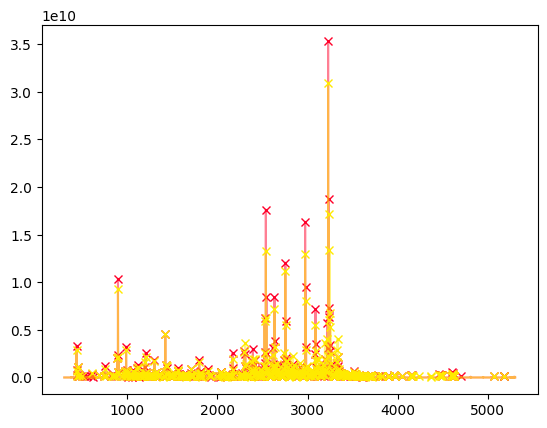

In [194]:
from scipy.signal import find_peaks
from sklearn.metrics import roc_auc_score

for index, v in enumerate(values_per_region):
    if v not in [0, 1]:
        continue
    values = np.float32(values_per_region[v])
    others = []
    for other_v in values_per_region:
        if other_v not in [0, 1]:
            continue

        if other_v != v:
            others.extend(values_per_region[other_v])
    others = np.float32(others)
    
    labels = [1] * len(values) + [0] * len(others)


    if len(values) > 0:
        result = np.percentile(values, 30, axis=0)
        peaks, _ = find_peaks(result, height=(0.01 * 1e10, None))
        plt.plot(np.arange(len(result)) + 300, result, color = colors_for_components[index], alpha=0.5)
        plt.plot(peaks + 300, result[peaks], "x", color = colors_for_components[index])

        for mz in peaks:
            auc = roc_auc_score(labels, np.concatenate((values[:, mz], others[:, mz]), axis=0))
            if auc > 0.7:
                print(index, 300 + mz/5, auc)
